## DistilBERT Fine-Tuning 

In [47]:
import torch
from torch.optim import AdamW
from torch.utils.data import DataLoader, Dataset
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer
from transformers import Trainer, TrainingArguments
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
from datasets import load_dataset
from sklearn.metrics import *
import helpers as helpers
import torch.nn as nn

In [2]:
# DistilBERT: max_len=128–256, batch_size=16, lr≈2e-5, epochs=2–3, early stopping.

DEPRESSION_PATH = "data/depression_dataset_reddit_cleaned.csv"
TDT_SPLIT = "80/10/10"
BERT_MODEL = 'distilbert-base-uncased'

MAX_LENGTH = 256
BATCH_SIZE = 16
NUM_EPOCHS = 3
LEARNING_RATE = 2e-5
WEIGHT_DECAY = 0.01

In [3]:
data, labels = helpers.get_data()
train_text, dev_text, test_text = helpers.split(data=data, dist=TDT_SPLIT)
train_dep, dev_dep, test_dep = helpers.split(data=labels, dist=TDT_SPLIT)

# convert data, labels into a pandas DataFrame
df = pd.DataFrame({'clean_text': data, 'is_depression': labels})

Completing 80/10/10 split
Completing 80/10/10 split


In [4]:
# initialize tokenizer
tokenizer = DistilBertTokenizer.from_pretrained(BERT_MODEL)
bert = DistilBertForSequenceClassification.from_pretrained(BERT_MODEL, num_labels=2)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
# stats from tokenizers
print("Vocab length is : ",len(tokenizer.vocab))
print(tokenizer.decode(2897))

vocab = list(tokenizer.vocab.keys())
print(f"first 10: {vocab[:10]}")
print(f"1280-1290: {vocab[1280:1290]}")
print(f"last 10: {vocab[-10:]}")

print(f"token 2897: {tokenizer.decode(2897)}")
print(f"token 102: {tokenizer.decode(102)}")
print(f"token 103: {tokenizer.decode(103)}")
if 'alex' in tokenizer.vocab:
  print(f"alex id: {tokenizer.vocab['alex']}")
else:
  print("alex not found")

Vocab length is :  30522
network
first 10: ['[PAD]', '[unused0]', '[unused1]', '[unused2]', '[unused3]', '[unused4]', '[unused5]', '[unused6]', '[unused7]', '[unused8]']
1280-1290: ['ر', 'ز', 'س', 'ش', 'ص', 'ض', 'ط', 'ظ', 'ع', 'غ']
last 10: ['##！', '##（', '##）', '##，', '##－', '##．', '##／', '##：', '##？', '##～']
token 2897: network
token 102: [SEP]
token 103: [MASK]
alex id: 4074


In [6]:
# tokenize train, dev, and test
train_encodings = tokenizer(train_text, truncation=True, padding=True, max_length=MAX_LENGTH, return_tensors="pt")
dev_encodings = tokenizer(dev_text, truncation=True, padding=True, max_length=MAX_LENGTH, return_tensors="pt")
test_encodings = tokenizer(test_text, truncation=True, padding=True, max_length=MAX_LENGTH, return_tensors="pt")

In [ ]:
# custom dataset class
class DepressionDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    
    def __getitem__(self, idx):
        item = {
            'input_ids': self.encodings['input_ids'][idx],
            'attention_mask': self.encodings['attention_mask'][idx],
            'labels': self.labels[idx]
        }
        return item
    
    def __len__(self):
        return len(self.labels)

In [8]:
# Convert labels to tensors
train_labels = torch.tensor(train_dep)
dev_labels = torch.tensor(dev_dep)
test_labels = torch.tensor(test_dep)

# Create datasets using the custom class
train_dataset = DepressionDataset(train_encodings, train_labels)
dev_dataset = DepressionDataset(dev_encodings, dev_labels)
test_dataset = DepressionDataset(test_encodings, test_labels)

# Create DataLoaders (for manual training if needed)
dl_train = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
dl_dev = DataLoader(dev_dataset, batch_size=BATCH_SIZE, shuffle=False)
dl_test = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [9]:
optimizer = AdamW(bert.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
loss_fn = nn.CrossEntropyLoss()

In [18]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return {
        'accuracy': accuracy_score(labels, predictions),
        'f1': f1_score(labels, predictions),
        'precision': precision_score(labels, predictions),
        'recall': recall_score(labels, predictions)
    }

In [12]:
# begin training
# using hugging face built in trainer https://huggingface.co/blog/davidberenstein1957/fine-tune-modernbert-on-synthetic-data#:~:text=the%20training%20arguments.-,from%20huggingface_hub%20import%20HfFolder,-from%20transformers%20import

training_args = TrainingArguments(
    output_dir="./distilbert-depression-classifier",
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    learning_rate=2e-5,
    num_train_epochs=NUM_EPOCHS,
    weight_decay=WEIGHT_DECAY,
    logging_dir='./logs',
    logging_strategy="steps",
    logging_steps=100,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
)

trainer = Trainer(
    model=bert,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=dev_dataset,
    compute_metrics=compute_metrics,
)
trainer.train()

/Users/griffinmichalak/Desktop/code/fall25/nlp/nlp-final-project/venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.027600,0.079178,0.979301,0.979644,0.977157,0.982143
2,0.002400,0.095119,0.980595,0.980645,0.992167,0.969388
3,0.000200,0.101041,0.981889,0.982051,0.987113,0.977041


/Users/griffinmichalak/Desktop/code/fall25/nlp/nlp-final-project/venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/griffinmichalak/Desktop/code/fall25/nlp/nlp-final-project/venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


TrainOutput(global_step=1161, training_loss=0.01272834973164307, metrics={'train_runtime': 589.4183, 'train_samples_per_second': 31.475, 'train_steps_per_second': 1.97, 'total_flos': 1228767589933056.0, 'train_loss': 0.01272834973164307, 'epoch': 3.0})

In [32]:
def eval_model(predictions_output):
    # outputs prior to softmax
    pred_logits = predictions_output.predictions
    pred_probs = None

    # use softmax: logits -> probs 
    pred_probs = np.exp(pred_logits) / np.sum(np.exp(pred_logits), axis=1, keepdims=True)
    y_scores = pred_probs[:, 1] # prob of true class

    y_pred = np.argmax(pred_logits, axis=1)
    y_true = predictions_output.label_ids

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    # pr_auc
    try:
        pr_auc = average_precision_score(y_true, y_scores)
    except ValueError:
        pr_auc = float('nan')

    # roc_auc
    try:
        roc_auc = roc_auc_score(y_true, y_scores)
    except ValueError:
        roc_auc = float('nan')

    return accuracy, precision, recall, f1, pr_auc, roc_auc

In [ ]:
# Get metrics to evaluate BERT Model

# generate predictions and outputs for dev
predictions_output_dev = trainer.predict(dev_dataset)
accuracy, precision, recall, f1, pr_auc, roc_auc = eval_model(predictions_output_dev)

print("Dev Dataset Metrics")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"PR-AUC: {pr_auc:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")


/Users/griffinmichalak/Desktop/code/fall25/nlp/nlp-final-project/venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Accuracy: 0.9819
Precision: 0.9871
Recall: 0.9770
F1 Score: 0.9821
PR-AUC: 0.9969
ROC-AUC: 0.9958


In [34]:
# evaluate our model on test
predictions_output_test = trainer.predict(test_dataset)
accuracy, precision, recall, f1, pr_auc, roc_auc = eval_model(predictions_output_test)

print("Test Dataset Metrics")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"PR-AUC: {pr_auc:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")

/Users/griffinmichalak/Desktop/code/fall25/nlp/nlp-final-project/venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Test Dataset Metrics
Accuracy: 0.9767
Precision: 0.9733
Recall: 0.9785
F1 Score: 0.9759
PR-AUC: 0.9982
ROC-AUC: 0.9983


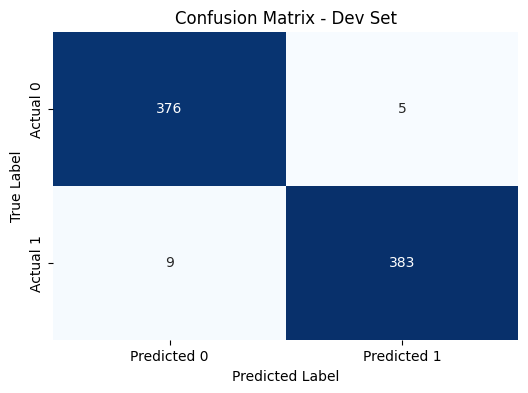

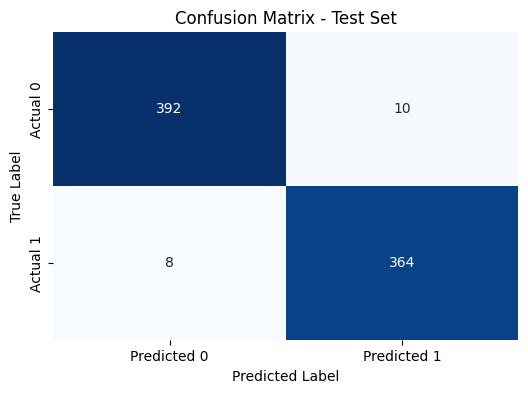

In [ ]:
# graphs

# Dev set confusion matrix
y_true_dev = [x['labels'] for x in dev_dataset]
y_pred_dev = predictions_output_dev.predictions.argmax(axis=1)

cm_dev = confusion_matrix(y_true_dev, y_pred_dev)
plt.figure(figsize=(6,4))
sns.heatmap(cm_dev, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Predicted 0', 'Predicted 1'], 
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Dev Set')
plt.show()

# Test set confusion matrix
y_true_test = [x['labels'] for x in test_dataset]
y_pred_test = predictions_output_test.predictions.argmax(axis=1)

cm_test = confusion_matrix(y_true_test, y_pred_test)
plt.figure(figsize=(6,4))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Predicted 0', 'Predicted 1'], 
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Test Set')
plt.show()

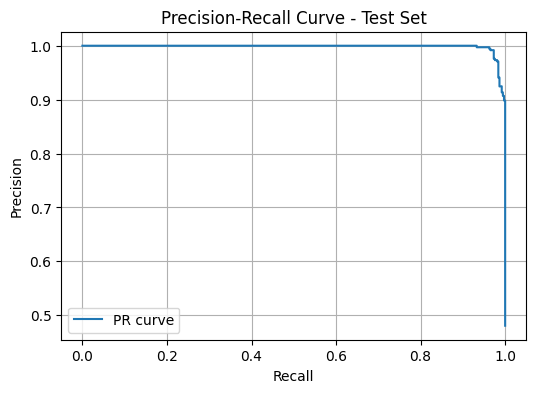

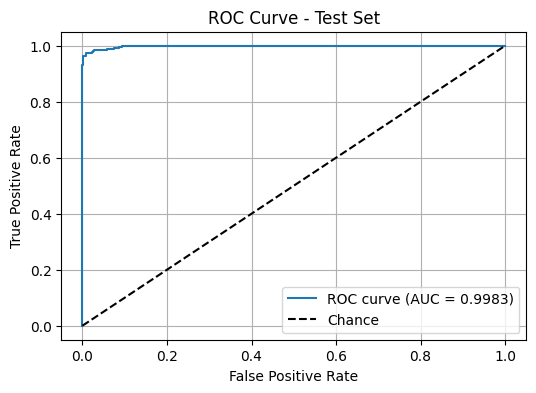

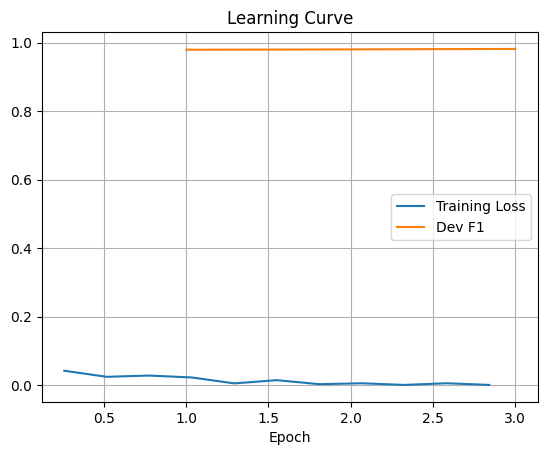

In [ ]:
# Precision-Recall curve for Test Set

# We need the true labels and predicted probabilities for the positive class
y_true_test = [x['labels'] for x in test_dataset]
if hasattr(predictions_output_test, "probabilities"):
    # HuggingFace >= v4.35.0
    y_scores_test = predictions_output_test.probabilities[:,1]
else:
    # fallback to logits
    y_scores_test = torch.softmax(torch.tensor(predictions_output_test.predictions), dim=1)[:,1].numpy()

precision, recall, pr_thresholds = precision_recall_curve(y_true_test, y_scores_test)

plt.figure(figsize=(6,4))
plt.plot(recall, precision, label='PR curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Test Set')
plt.grid()
plt.legend()
plt.show()

# ROC curve for Test Set
fpr, tpr, roc_thresholds = roc_curve(y_true_test, y_scores_test)
roc_auc = roc_auc_score(y_true_test, y_scores_test)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Test Set')
plt.grid()
plt.legend()
plt.show()

# Learning curve: training loss and dev F1 vs. epoch
training_logs = []
dev_f1s = []
epochs = []

if hasattr(trainer, "state") and hasattr(trainer.state, "log_history"):
    log_history = trainer.state.log_history
else:
    log_history = []

for log in log_history:
    if "loss" in log and "epoch" in log:
        training_logs.append((log["epoch"], log["loss"]))
    if "eval_f1" in log and "epoch" in log:
        dev_f1s.append((log["epoch"], log["eval_f1"]))

if training_logs:
    train_loss_df = pd.DataFrame(training_logs, columns=['epoch', 'train_loss'])
    train_loss_df = train_loss_df.groupby('epoch').mean().reset_index()
    plt.plot(train_loss_df['epoch'], train_loss_df['train_loss'], label="Training Loss")
if dev_f1s:
    dev_f1_df = pd.DataFrame(dev_f1s, columns=['epoch', 'dev_f1'])
    dev_f1_df = dev_f1_df.groupby('epoch').max().reset_index()
    plt.plot(dev_f1_df['epoch'], dev_f1_df['dev_f1'], label="Dev F1")

plt.xlabel("Epoch")
plt.title("Learning Curve")
plt.legend()
plt.grid()
plt.show()